In [ ]:
import os
import json

import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import URL, create_engine
from faker import Faker
import httpx

In [4]:
fake = Faker()

load_dotenv(".env")

url = URL.create(
    drivername=os.getenv("DATABASE_PREFIX"),
    username=os.getenv("DATABASE_USER"),
    password=os.getenv("DATABASE_PASSWORD"),
    host=os.getenv("DATABASE_HOST"),
    port=os.getenv("DATABASE_PORT"),
    database=os.getenv("DATABASE_DB"),
).render_as_string(hide_password=False)

engine = create_engine(url, echo=True)
with engine.connect() as connection:
    df = pd.read_sql_table("report", connection)

2025-02-15 02:05:44,828 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2025-02-15 02:05:44,829 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-02-15 02:05:44,831 INFO sqlalchemy.engine.Engine select current_schema()
2025-02-15 02:05:44,832 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-02-15 02:05:44,834 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2025-02-15 02:05:44,834 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-02-15 02:05:44,836 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-02-15 02:05:44,841 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

In [5]:
df = df.drop(columns=["id", "report_type", "created_at", "updated_at", "department_id"])
df

,property
0,"{'address': 'АСТАНА КОСШЫ РЫСКУЛОВА 28А', 'fi..."
1,"{'address': 'АСТАНА АСТАНА КЕНЕСАРЫ 311', 'f..."
2,{'address': 'АСТАНА АСТАНА ПОС ИНТЕРНАЦИОНАЛ...
3,{'address': 'АСТАНА АСТАНА АЛИХАН БОКЕЙХАНОВА...
4,"{'address': 'АСТАНА АСТАНА АБЫЛАЙ ХАНА 5/3', ..."
...,...
1822,"{'email': 'kuatbek_amanbay@icloud.com', 'fio_t..."
1823,"{'email': 'guli.toleuova1994@gmail.com', 'fio_..."
1824,"{'email': 'gulim19@mail.ru', 'fio_too': 'ЖАКАН..."
1825,"{'email': 'p.yuliya28@gmail.com', 'fio_too': '..."


In [6]:
df_normalized = df.copy()

# get unique keys from list of dictionaries
unique_keys = set()
df_normalized["property"].apply(lambda x: unique_keys.update(x.keys()))
display(unique_keys)

{'address',
 'aktivy_v_btc',
 'aktivy_v_usd',
 'assets_overview',
 'binance_pay_buy_crypto',
 'binance_pay_buy_crypto_usdt',
 'binance_pay_sell_crypto',
 'binance_pay_sell_crypto_usdt',
 'binance_send',
 'binance_send_usdt',
 'birzha',
 'buy_amount',
 'crypto_deposit_busd',
 'crypto_deposit_history',
 'crypto_withdrawal_busd',
 'crypto_withdrawal_history',
 'data_pervoy_operacii_binance_pay_crypto',
 'data_pervoy_operacii_binance_send',
 'data_pervoy_operacii_crypto_deposit',
 'data_pervoy_operacii_crypto_withdrawal',
 'data_pervoy_operacii_fiat_deposit',
 'data_pervoy_operacii_fiat_withdrawal',
 'data_pervoy_operacii_p2p_buy_crypto',
 'data_pervoy_operacii_p2p_sell_crypto',
 'data_posledney_operacii_binance_pay_crypto',
 'data_posledney_operacii_binance_send',
 'data_posledney_operacii_crypto_deposit',
 'data_posledney_operacii_crypto_withdrawal',
 'data_posledney_operacii_fiat_deposit',
 'data_posledney_operacii_fiat_withdrawal',
 'data_posledney_operacii_p2p_buy_crypto',
 'data_posl

In [7]:
# remove not usefull keys for analysis
unique_keys = {
    'address',
    'email',
    'fio_polzovatelya',
    'fio_too',
    'geolokaciya',
    'iin_bin',
    'name',
    'nomer_pasporta_udostovereniya',
    'telefon',
    'telephone',
}

# use only this keys from each dictionary in list
df_normalized["property"] = df_normalized["property"].apply(
    lambda x: {k: v for k, v in x.items() if k in unique_keys}
)

df_normalized 

,property
0,"{'address': 'АСТАНА КОСШЫ РЫСКУЛОВА 28А', 'fi..."
1,"{'address': 'АСТАНА АСТАНА КЕНЕСАРЫ 311', 'f..."
2,{'address': 'АСТАНА АСТАНА ПОС ИНТЕРНАЦИОНАЛ...
3,{'address': 'АСТАНА АСТАНА АЛИХАН БОКЕЙХАНОВА...
4,"{'address': 'АСТАНА АСТАНА АБЫЛАЙ ХАНА 5/3', ..."
...,...
1822,"{'email': 'kuatbek_amanbay@icloud.com', 'fio_t..."
1823,"{'email': 'guli.toleuova1994@gmail.com', 'fio_..."
1824,"{'email': 'gulim19@mail.ru', 'fio_too': 'ЖАКАН..."
1825,"{'email': 'p.yuliya28@gmail.com', 'fio_too': '..."


In [8]:
# flatten json to dataframe
df_normalized = df_normalized.join(pd.json_normalize(df_normalized["property"]))
df_normalized = df_normalized.drop(columns=["property"])
df_normalized

,address,fio_too,iin_bin,email,telefon,geolokaciya,fio_polzovatelya,nomer_pasporta_udostovereniya,name,telephone
0,АСТАНА КОСШЫ РЫСКУЛОВА 28А,Хисамутдинова Камила Маратовна,20127651276,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,АСТАНА АСТАНА КЕНЕСАРЫ 311,Жолдыбаев Андрей Андреевич,960424351772,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,АСТАНА АСТАНА ПОС ИНТЕРНАЦИОНАЛЬНЫЙ МЕРЕКЕ 9/2,Кобзева Алина Игоревна,706651258,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,АСТАНА АСТАНА АЛИХАН БОКЕЙХАНОВА 17,Сыздыков Тамерлан Ренатович,991216351284,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,АСТАНА АСТАНА АБЫЛАЙ ХАНА 5/3,Мобей Арафат Ахмедович,60917000047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1822,NaN,КУАТБЕК АМАНБАЙ САМАТУЛЫ,010402550492,kuatbek_amanbay@icloud.com,+77755948615,"KZ Astana, Kazakhstan Aktau, Kazakhstan Aktobe...",AMANBAY KUATBEK,042572978,NaN,NaN
1823,NaN,ТОЛЕУБАЕВ ЖАСУЛАН СЕРИКБАЕВИЧ,970314351657,guli.toleuova1994@gmail.com,+77762115491,"Canada Toronto, KZ Almaty, Kazakhstan Aktau, K...",ZHASSULAN TOLEUBAYEV,047921194,NaN,NaN
1824,NaN,ЖАКАНОВА ГУЛИМ ЗЕЙНОЛЛОВНА,871026450651,gulim19@mail.ru,+77779696566,"Azerbaijan Baku, Georgia Batumi, Georgia Tbili...",GULIM ZHAKANOVA,036720790,NaN,NaN
1825,NaN,ТУРКМЕНБАЕВА ЮЛИЯ АНДРЕЕВНА,920604400666,p.yuliya28@gmail.com,+77763042222,"Egypt Cairo, IN Mumbai, Ireland Dublin, KR Seo...",YULIYA TURKMENBAYEVA,047595515,NaN,NaN


In [9]:
# data anonymization of confidential data to fake data (identifier, phone, email, etc.)
from faker.providers.address.ru_RU import Provider as AddressProvider
from faker.providers.company.ru_RU import Provider as CompanyProvider
from faker.providers.internet.ru_RU import Provider as InternetProvider
from faker.providers.person.ru_RU import Provider as PersonProvider
from faker.providers.phone_number.ru_RU import Provider as PhoneProvider
from faker.providers.passport.ru_RU import Provider as PassportProvider

Faker.seed(0)
fake.add_provider(AddressProvider)
fake.add_provider(CompanyProvider)
fake.add_provider(InternetProvider)
fake.add_provider(PersonProvider)
fake.add_provider(PhoneProvider)
fake.add_provider(PassportProvider)

def anonymize_data(df):
    df["identifier"] = [fake.individuals_inn() for _ in range(len(df))]
    df["passport_number"] = [fake.passport_number() for _ in range(len(df))]
    df["email"] = [fake.free_email() for _ in range(len(df))]
    df["phone_number"] = [fake.phone_number() for _ in range(len(df))]
    df["full_name"] = [fake.name() for _ in range(len(df))]
    return df

df_anonymized = df_normalized.copy()
df_anonymized = anonymize_data(df_anonymized)
df_anonymized = df_anonymized.drop(columns=["telephone", "telefon", "fio_too", "fio_polzovatelya", "nomer_pasporta_udostovereniya", "iin_bin", "name"])
df_anonymized

,address,email,geolokaciya,identifier,passport_number,phone_number,full_name
0,АСТАНА КОСШЫ РЫСКУЛОВА 28А,mpavlov@yahoo.com,NaN,509893348943,4839 409651,+7 680 711 91 73,тов. Харитонова Нонна Валентиновна
1,АСТАНА АСТАНА КЕНЕСАРЫ 311,litkinratmir@mail.ru,NaN,540627149425,4514 925009,+7 (182) 290-13-37,Глафира Егоровна Наумова
2,АСТАНА АСТАНА ПОС ИНТЕРНАЦИОНАЛЬНЫЙ МЕРЕКЕ 9/2,vorobevfoti@hotmail.com,NaN,666342460503,0636 974029,+7 (043) 755-60-48,Зоя Васильевна Молчанова
3,АСТАНА АСТАНА АЛИХАН БОКЕЙХАНОВА 17,hristofor45@yahoo.com,NaN,396237544280,8100 126692,8 (733) 870-02-16,г-н Наумов Мир Еремеевич
4,АСТАНА АСТАНА АБЫЛАЙ ХАНА 5/3,leliseev@gmail.com,NaN,752852920309,81 00 664260,8 (484) 257-95-17,Никонова Раиса Юрьевна
...,...,...,...,...,...,...,...
1822,NaN,hhohlova@rambler.ru,"KZ Astana, Kazakhstan Aktau, Kazakhstan Aktobe...",649769053365,19 84 721490,+7 (961) 652-7925,Зоя Степановна Голубева
1823,NaN,osipovkallistrat@yandex.ru,"Canada Toronto, KZ Almaty, Kazakhstan Aktau, K...",266730503442,91 04 151259,+79039091965,г-жа Алексеева Октябрина Филипповна
1824,NaN,lguseva@yandex.ru,"Azerbaijan Baku, Georgia Batumi, Georgia Tbili...",749559549632,66 91 110226,+77367516718,г-жа Устинова Лидия Васильевна
1825,NaN,filatovkir@mail.ru,"Egypt Cairo, IN Mumbai, Ireland Dublin, KR Seo...",122039080600,7262 436206,+7 953 288 2831,тов. Владимирова Жанна Станиславовна


In [10]:
# drop rows where both address and geolokaciya is NaN
df_anonymized = df_anonymized.dropna(subset=["address", "geolokaciya"], how="all")

In [11]:
# some data analysis
# TODO: merge address + geolokaciya
df_anonymized["address"].value_counts()
print(df_anonymized["address"].isna().sum(), df_anonymized["geolokaciya"].isna().sum())
df_anonymized.describe()

98 1643


,address,email,geolokaciya,identifier,passport_number,phone_number,full_name
count,1643,1741,98,1741,1741,1741,1741
unique,1366,1741,95,1741,1741,1741,1741
top,"Г. АКТОБЕ, П. КУРАЙЛЫ, 397Б",noskovjuri@mail.ru,Kazakhstan Almaty,700192664185,2607 113596,8 (773) 342-9034,г-н Крылов Петр Антонович
freq,5,1,3,1,1,1,1


In [ ]:
# data normalization according to some special format
# подавать несколько адресов одновременно для обработки

system_prompt = """
You are tasked with address normalization. For every set of 5 addresses in Russian or Kazakh, follow these instructions:

1. Translate the each addresses to only Russian.
2. Normalize the addresses to OpenStreetMap (OSM) format like in Russia:
- like tags: country, state, city, city, quarter, suburb, place, street, housenumber, housenumber, entrance, and others if available.
- if not all tags are available, use the most specific ones or less that you could. SO DON'T HALUCINATE THE MISSING ONES.
3. Remove other duplicates, information in brackets, gargabe information out of context, but NOT SHORTENING.
4. ONLY provide the normalized addresses in OSM format, WITHOUT ANY ANY EXPLANATION.
5. Each input will consist of 5 addresses in multiple lines. Process them accordingly and output the normalized OSM addresses.

- Example input:
Россия, Москва, ул. Тверская, д. 7  
Казахстан, Алматы, проспект Абая, 44  
Россия, Санкт-Петербург, Невский проспект, дом 10, кв. 5
- Example output:
[
    {
        "country": "Россия",
        "state": "Москва",
        "city": "Москва",
        "street": "улица Тверская",
        "housenumber": "7"
    },
    {
        "country": "Казахстан",
        "state": "Алматы",
        "city": "Алматы",
        "street": "Проспект Абая",
        "housenumber": "44"
    },
    {
        "country": "Россия",
        "state": "Санкт-Петербург",
        "city": "Санкт-Петербург",
        "street": "Невский проспект",
        "housenumber": "10",
        "place": "квартира 5"
    }
]
"""

user_prompt = """
Normalize the following addresses to OpenStreetMap (OSM) format, each in new line: {}
"""

# max tokens, temperature, top_p, top_k, etc. can be used
def normalize_batch_addresses(addresses: list[str]): # -> list[str]:
    url = "http://localhost:8080/v1/chat/completions"
    headers = {
        "Content-Type": "application/json",
    }
    data = {
        "model": "gpt-3.5-turbo",
        "messages": [
            {
                "role": "system",
                "content": system_prompt
            },
            {
                "role": "user",
                "content": user_prompt.format("\n".join(addresses))
            }
        ],
        # "response_format": {
        #     "type": "json_object"
        # }
    }
    with httpx.Client(timeout=None) as client:
        request = client.post(url, headers=headers, json=data) # response status handle
        response = request.json()["choices"][0]["message"]["content"]
    # TODO: strict json validation and retrying
    return json.loads(response)

batch_size = 5
normalized_addresses = []
for i in range(0, min(100, len(df_anonymized["address"])), batch_size): # for i in range(0, len(df_anonymized["address"]), batch_size):
    batch = df_anonymized["address"].iloc[i:i + batch_size].dropna().tolist()
    if batch:
        normalized_batch = normalize_batch_addresses(batch)
        normalized_addresses.extend(normalized_batch)
df_anonymized["normalized_address"] = pd.Series(normalized_addresses)

# TODO:
# генерируем искуственый датасет или настоящий из верных форматов адрессов для обучения модели
# can be used external API: claude, openai, deepseek, etc.
# определяем какой формат адресов необходимо использовать
# предварительная обработка записей с убиранием дубликатов названий, приведение к определенному формату и регистру т.д.
# df_anonymized["address"] = df_anonymized["address"].str.lower()
# обучаем 
# нужно использовать multilingual модель предобученную ведь данные и на казахском, и на русском, и на английском моменты
# либо все переводить только на английский заранее
# todo: нужна возможность как то сравнить before and after результаты

/tmp/ipykernel_78602/178278023.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anonymized["normalized_address"] = pd.Series(normalized_addresses)


In [65]:
normalized_addresses

[{'country': 'Казахстан',
  'state': 'Алматы',
  'city': 'Алматы',
  'street': 'Пк.Рыскулова',
  'housenumber': '28'},
 {'country': 'Казахстан',
  'state': 'Алматы',
  'city': 'Алматы',
  'street': 'Пр.Кенесары',
  'housenumber': '311'},
 {'country': 'Казахстан',
  'state': 'Алматы',
  'city': 'Алматы',
  'street': 'П.С Интернациональный',
  'housenumber': '9/2'},
 {'country': 'Казахстан',
  'state': 'Алматы',
  'city': 'Алматы',
  'street': 'А.С Алихан Бокейханова',
  'housenumber': '17'},
 {'country': 'Казахстан',
  'state': 'Алматы',
  'city': 'Алматы',
  'street': 'А.С Абылай Хана',
  'housenumber': '5/3'},
 {'country': '',
  'state': '',
  'city': 'Алматы',
  'street': 'улица Жаяубута',
  'housenumber': '420'},
 {'country': '',
  'state': '',
  'city': 'Алматы',
  'street': 'Райымбека',
  'housenumber': '417'},
 {'country': '', 'state': '', 'city': 'Алматы', 'street': ''},
 {'country': '',
  'state': 'Капчагай',
  'city': 'Капчагай',
  'street': 'улица Капчагайская',
  'housenumbe

In [66]:
df_anonymized

,address,email,geolokaciya,identifier,passport_number,phone_number,full_name,normalized_address
0,АСТАНА КОСШЫ РЫСКУЛОВА 28А,mpavlov@yahoo.com,NaN,509893348943,4839 409651,+7 680 711 91 73,тов. Харитонова Нонна Валентиновна,"{'country': 'Казахстан', 'state': 'Алматы', 'c..."
1,АСТАНА АСТАНА КЕНЕСАРЫ 311,litkinratmir@mail.ru,NaN,540627149425,4514 925009,+7 (182) 290-13-37,Глафира Егоровна Наумова,"{'country': 'Казахстан', 'state': 'Алматы', 'c..."
2,АСТАНА АСТАНА ПОС ИНТЕРНАЦИОНАЛЬНЫЙ МЕРЕКЕ 9/2,vorobevfoti@hotmail.com,NaN,666342460503,0636 974029,+7 (043) 755-60-48,Зоя Васильевна Молчанова,"{'country': 'Казахстан', 'state': 'Алматы', 'c..."
3,АСТАНА АСТАНА АЛИХАН БОКЕЙХАНОВА 17,hristofor45@yahoo.com,NaN,396237544280,8100 126692,8 (733) 870-02-16,г-н Наумов Мир Еремеевич,"{'country': 'Казахстан', 'state': 'Алматы', 'c..."
4,АСТАНА АСТАНА АБЫЛАЙ ХАНА 5/3,leliseev@gmail.com,NaN,752852920309,81 00 664260,8 (484) 257-95-17,Никонова Раиса Юрьевна,"{'country': 'Казахстан', 'state': 'Алматы', 'c..."
...,...,...,...,...,...,...,...,...
1822,NaN,hhohlova@rambler.ru,"KZ Astana, Kazakhstan Aktau, Kazakhstan Aktobe...",649769053365,19 84 721490,+7 (961) 652-7925,Зоя Степановна Голубева,NaN
1823,NaN,osipovkallistrat@yandex.ru,"Canada Toronto, KZ Almaty, Kazakhstan Aktau, K...",266730503442,91 04 151259,+79039091965,г-жа Алексеева Октябрина Филипповна,NaN
1824,NaN,lguseva@yandex.ru,"Azerbaijan Baku, Georgia Batumi, Georgia Tbili...",749559549632,66 91 110226,+77367516718,г-жа Устинова Лидия Васильевна,NaN
1825,NaN,filatovkir@mail.ru,"Egypt Cairo, IN Mumbai, Ireland Dublin, KR Seo...",122039080600,7262 436206,+7 953 288 2831,тов. Владимирова Жанна Станиславовна,NaN


In [71]:
# address search, store geolocation, fuzzy search
from fake_useragent import UserAgent
from geopy.geocoders import Nominatim

user_agent = UserAgent()
geolocator = Nominatim(user_agent=user_agent.random)

def combine_address_components(address_dict):
    if isinstance(address_dict, dict):
        return ", ".join(address_dict.values())
    return ""

df_anonymized["combined_address"] = df_anonymized["normalized_address"].apply(combine_address_components)
# df_anonymized["geolocation"] = df_anonymized["combined_address"].apply(lambda x: geolocator.geocode(x))
df_anonymized

/tmp/ipykernel_78602/1014676589.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anonymized["combined_address"] = df_anonymized["normalized_address"].apply(combine_address_components)


,address,email,geolokaciya,identifier,passport_number,phone_number,full_name,normalized_address,combined_address
0,АСТАНА КОСШЫ РЫСКУЛОВА 28А,mpavlov@yahoo.com,NaN,509893348943,4839 409651,+7 680 711 91 73,тов. Харитонова Нонна Валентиновна,"{'country': 'Казахстан', 'state': 'Алматы', 'c...","Казахстан, Алматы, Алматы, Пк.Рыскулова, 28"
1,АСТАНА АСТАНА КЕНЕСАРЫ 311,litkinratmir@mail.ru,NaN,540627149425,4514 925009,+7 (182) 290-13-37,Глафира Егоровна Наумова,"{'country': 'Казахстан', 'state': 'Алматы', 'c...","Казахстан, Алматы, Алматы, Пр.Кенесары, 311"
2,АСТАНА АСТАНА ПОС ИНТЕРНАЦИОНАЛЬНЫЙ МЕРЕКЕ 9/2,vorobevfoti@hotmail.com,NaN,666342460503,0636 974029,+7 (043) 755-60-48,Зоя Васильевна Молчанова,"{'country': 'Казахстан', 'state': 'Алматы', 'c...","Казахстан, Алматы, Алматы, П.С Интернациональн..."
3,АСТАНА АСТАНА АЛИХАН БОКЕЙХАНОВА 17,hristofor45@yahoo.com,NaN,396237544280,8100 126692,8 (733) 870-02-16,г-н Наумов Мир Еремеевич,"{'country': 'Казахстан', 'state': 'Алматы', 'c...","Казахстан, Алматы, Алматы, А.С Алихан Бокейхан..."
4,АСТАНА АСТАНА АБЫЛАЙ ХАНА 5/3,leliseev@gmail.com,NaN,752852920309,81 00 664260,8 (484) 257-95-17,Никонова Раиса Юрьевна,"{'country': 'Казахстан', 'state': 'Алматы', 'c...","Казахстан, Алматы, Алматы, А.С Абылай Хана, 5/3"
...,...,...,...,...,...,...,...,...,...
1822,NaN,hhohlova@rambler.ru,"KZ Astana, Kazakhstan Aktau, Kazakhstan Aktobe...",649769053365,19 84 721490,+7 (961) 652-7925,Зоя Степановна Голубева,NaN,
1823,NaN,osipovkallistrat@yandex.ru,"Canada Toronto, KZ Almaty, Kazakhstan Aktau, K...",266730503442,91 04 151259,+79039091965,г-жа Алексеева Октябрина Филипповна,NaN,
1824,NaN,lguseva@yandex.ru,"Azerbaijan Baku, Georgia Batumi, Georgia Tbili...",749559549632,66 91 110226,+77367516718,г-жа Устинова Лидия Васильевна,NaN,
1825,NaN,filatovkir@mail.ru,"Egypt Cairo, IN Mumbai, Ireland Dublin, KR Seo...",122039080600,7262 436206,+7 953 288 2831,тов. Владимирова Жанна Станиславовна,NaN,


In [ ]:
import matplotlib.pyplot as plt

latitudes_combined = []
longitudes_combined = []
latitudes_address = []
longitudes_address = []

# df[combined_address] (100 rows)
found_combined = 0
for i, row in df_anonymized.head(100).iterrows():
    location = geolocator.geocode(row["combined_address"])
    if location:
        latitudes_combined.append(location.latitude)
        longitudes_combined.append(location.longitude)
        found_combined += 1

# df[address] (100 rows)
found_address = 0
for i, row in df_anonymized.head(100).iterrows():
    location = geolocator.geocode(row["address"])
    if location:
        latitudes_address.append(location.latitude)
        longitudes_address.append(location.longitude)
        found_address += 1

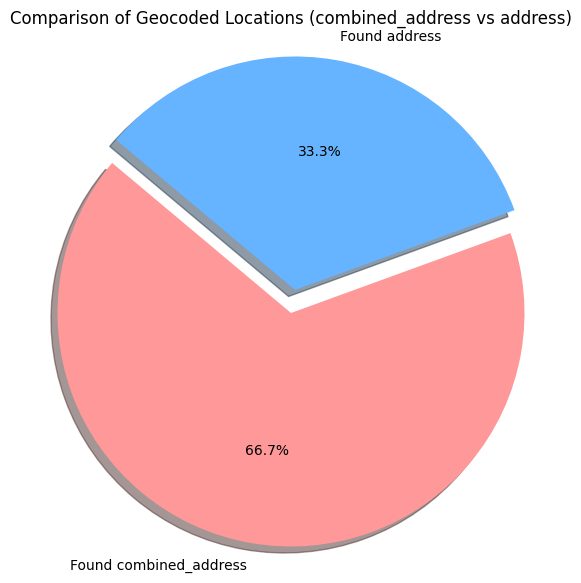

In [ ]:
labels = ['Found combined_address', 'Found address']
sizes = [found_address, found_combined] # [found_combined, found_address]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)
plt.figure(figsize=(7, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Comparison of Geocoded Locations (combined_address vs address)')
plt.axis('equal')
plt.show()

In [3]:
normalized_addresses = [{'country': 'Казахстан',
  'state': 'Алматы',
  'city': 'Алматы',
  'street': 'Пк.Рыскулова',
  'housenumber': '28'},
 {'country': 'Казахстан',
  'state': 'Алматы',
  'city': 'Алматы',
  'street': 'Пр.Кенесары',
  'housenumber': '311'},
 {'country': 'Казахстан',
  'state': 'Алматы',
  'city': 'Алматы',
  'street': 'П.С Интернациональный',
  'housenumber': '9/2'},
 {'country': 'Казахстан',
  'state': 'Алматы',
  'city': 'Алматы',
  'street': 'А.С Алихан Бокейханова',
  'housenumber': '17'},
 {'country': 'Казахстан',
  'state': 'Алматы',
  'city': 'Алматы',
  'street': 'А.С Абылай Хана',
  'housenumber': '5/3'},
 {'country': '',
  'state': '',
  'city': 'Алматы',
  'street': 'улица Жаяубута',
  'housenumber': '420'},
 {'country': '',
  'state': '',
  'city': 'Алматы',
  'street': 'Райымбека',
  'housenumber': '417'},
 {'country': '', 'state': '', 'city': 'Алматы', 'street': ''},
 {'country': '',
  'state': 'Капчагай',
  'city': 'Капчагай',
  'street': 'улица Капчагайская',
  'housenumber': '28'},
 {'country': '',
  'state': 'Алматы',
  'city': 'Алматы',
  'street': 'улица Токтогула',
  'housenumber': '15'},
 {'country': '',
  'state': 'Алматинская область',
  'city': 'Алма-Ата',
  'street': 'Ул. Охотнур-Йарабаев',
  'housenumber': '32'},
 {'country': '',
  'state': 'Алматинская область',
  'city': 'Алма-Ата',
  'street': 'Ул. Сарсен-Баева',
  'housenumber': '152'},
 {'country': '',
  'state': 'Алматинская область',
  'city': 'Алма-Ата',
  'street': 'Ул. Отанбелова',
  'housenumber': '64'},
 {'country': '',
  'state': 'Алматинская область',
  'city': 'Алма-Ата',
  'street': 'Ул. Шукщина',
  'housenumber': '71'},
 {'country': '',
  'state': 'Алматинская область',
  'city': 'Алма-Ата',
  'street': 'Ул. Зандосова',
  'housenumber': '34'},
 {'country': '',
  'state': 'АЛМАТИНСКАЯ ОБЛАСТЬ',
  'city': 'АЛМАТЫ',
  'street': 'Геологов',
  'housenumber': '1'},
 {'country': '',
  'state': 'АЛМАТИНСКАЯ ОБЛАСТЬ',
  'city': 'АЛМАТЫ',
  'street': 'улица Токtogula',
  'housenumber': '15'},
 {'country': '',
  'state': 'АЛМАТИНСКАЯ ОБЛАСТЬ',
  'city': 'АЛМАТЫ',
  'street': 'Розы Бакиевой',
  'housenumber': '147'},
 {'country': '',
  'state': '',
  'city': 'АЛМАТЫ',
  'street': 'Райымбека',
  'housenumber': '55'},
 {'country': '',
  'state': 'АЛМАТИНСКАЯ ОБЛАСТЬ',
  'city': 'АЛМАТЫ',
  'street': 'Бейсебаевой',
  'housenumber': '47'},
 {'country': 'Казахстан',
  'state': 'Акмолинская область',
  'city': 'Жаксынский район',
  'street': 'Проспект Абаева',
  'housenumber': '34'},
 {'country': 'Казахстан',
  'state': 'Акмолинская область',
  'city': 'Астана',
  'quarter': 'Поселок Костомар',
  'street': '',
  'housenumber': ''},
 {'country': 'Казахстан',
  'state': 'Акмолинская область',
  'city': 'Жаксынский район',
  'street': 'Улица Сейтжана Жакупова',
  'housenumber': '56'},
 {'country': 'Казахстан',
  'state': 'Актюбинская область',
  'city': 'Актобе',
  'street': 'Улица Некрасова',
  'housenumber': '136'},
 {'country': 'Казахстан',
  'state': 'Алматинская область',
  'city': 'Алматы',
  'quarter': '',
  'street': 'Улица Бейсебаева',
  'housenumber': '47'},
 {'country': '',
  'state': 'АЛМАТЫ',
  'city': 'АЛМАТЫ',
  'street': 'ЖАЯУБУТА',
  'housenumber': '420 А'},
 {'country': '',
  'state': 'АЛМАТЫ',
  'city': 'АЛМАТЫ',
  'street': 'РАЙЫМБЕКА',
  'housenumber': '417 А'},
 {'country': '',
  'state': 'АЛМАТИНСКАЯ ОБЛАСТЬ',
  'city': 'АЛМАТЫ',
  'street': ''},
 {'country': '',
  'state': 'АЛМАТИНСКАЯ ОБЛАСТЬ',
  'city': 'КАПЧАГАЙ',
  'street': 'Капчагайская',
  'housenumber': '28'},
 {'country': 'Казахстан',
  'state': 'Алматинская область',
  'city': 'Алма-Ата',
  'street': 'улица Токтогула',
  'housenumber': '15'},
 {'country': 'Казахстан',
  'state': 'Алматинская область',
  'city': 'Алма-Ата',
  'street': 'улица Оңалбай Әлим',
  'housenumber': '32'},
 {'country': 'Казахстан',
  'state': 'Алматинская область',
  'city': 'Алма-Ата',
  'street': 'улица Сарсенбаева',
  'housenumber': '152'},
 {'country': 'Казахстан',
  'state': 'Алматинская область',
  'city': 'Алма-Ата',
  'street': 'улица Ауезова',
  'housenumber': '64'},
 {'country': 'Казахстан',
  'state': 'Алматинская область',
  'city': 'Алма-Ата',
  'street': 'улица Шукшина',
  'housenumber': '71'},
 {'country': 'Казахстан',
  'state': 'Алматинская область',
  'city': 'Алматы',
  'street': 'Жандосова',
  'housenumber': '34А'},
 {'country': 'Казахстан',
  'state': 'Алматинская область',
  'city': 'Алматы',
  'street': 'Геологов',
  'housenumber': '1А'},
 {'country': 'Казахстан',
  'state': 'Алматинская область',
  'city': 'Алматы',
  'street': 'Улица Токтогула',
  'housenumber': '15'},
 {'country': 'Казахстан',
  'state': 'Алматинская область',
  'city': 'Алматы',
  'street': 'Розы Бакиевой',
  'housenumber': '147'},
 {'country': 'Казахстан',
  'city': 'Алматы',
  'street': 'Райымбека',
  'housenumber': '55'},
 {'country': 'Казахстан',
  'state': 'Алматинская область',
  'city': 'Алматы',
  'street': 'Бейсебаева',
  'housenumber': '47'},
 {'country': 'Казахстан',
  'state': 'Атырауская область',
  'city': 'Атырау',
  'street': 'Молдагалиева',
  'housenumber': '8А'},
 {'country': 'Казахстан',
  'state': 'Атырауская область',
  'city': 'Атырау',
  'street': 'Қайырғалі Смағұлов',
  'housenumber': '56А'},
 {'country': 'Казахстан',
  'state': 'Жамбыльская область',
  'city': 'Талас',
  'street': 'Талас',
  'housenumber': '18'},
 {'country': 'Казахстан',
  'state': 'Жамбыльская область',
  'city': 'Район Туран Рыскулова',
  'street': 'Саякбаи Аденулы',
  'housenumber': '34А'},
 {'country': 'Россия',
  'state': 'Костанайская область',
  'city': 'Костанай',
  'street': 'улица Карбышева',
  'housenumber': '17'},
 {'country': 'Россия',
  'state': 'Костанайская область',
  'city': 'Костанай',
  'street': 'улица Дощанова',
  'housenumber': '157'},
 {'country': 'Россия',
  'state': 'Костанайская область',
  'city': 'Денисовский район',
  'street': 'улица Новостроек',
  'housenumber': '3'},
 {'country': 'Россия',
  'state': 'Павлодарская область',
  'city': 'Павлодар',
  'street': 'улица Октябрьская',
  'housenumber': '109/1'},
 {'country': 'Россия',
  'state': 'Павлодарская область',
  'city': 'Павлодар',
  'street': '5-я промзона, Р. П. Переплавного завода'},
 {'country': '',
  'state': 'Павлодарская область',
  'city': 'Павлодар',
  'street': 'Улица Гагарина',
  'housenumber': '32'},
 {'country': '',
  'state': 'Астана',
  'city': 'Астана',
  'street': 'Переулок Цумабек Ташенев',
  'housenumber': '4/3 20'},
 {'country': '',
  'state': 'Астана',
  'city': 'Астана',
  'street': 'Улица Зумабек Ташенев',
  'housenumber': '23 68'},
 {'country': '',
  'state': 'Астана',
  'city': 'Астана',
  'street': 'Улица Роза Багланова',
  'housenumber': '2 190'},
 {'country': '',
  'state': 'Астана',
  'city': 'Хитер Демокучі',
  'street': 'Улица 13Ёлихан Вокейхан',
  'housenumber': '42 128'},
 {'country': '',
  'state': '',
  'city': '',
  'street': 'Улица Грёгорий Потанин',
  'housenumber': '20',
  'entrance': '2'},
 {'country': '',
  'state': '',
  'city': '',
  'street': 'Улица Сыганак',
  'housenumber': '64/1',
  'entrance': '20'},
 {'country': '',
  'state': '',
  'city': '',
  'street': 'Проспект Хабанбай Батыр',
  'housenumber': '60',
  'place': 'Корпус 3'},
 {'country': '',
  'state': '',
  'city': '',
  'street': 'Эсиль Улица Алихан Бокейхан',
  'housenumber': '17',
  'entrance': '48'},
 {'country': '',
  'state': '',
  'city': '',
  'street': 'Юсил Улица Казыбек',
  'housenumber': '11',
  'entrance': '80'},
 {'country': 'Россия',
  'state': 'Алма-Атинская область',
  'city': 'Астана',
  'street': 'Проспект Бауыржан Момышұлы',
  'housenumber': '10/2, 11'},
 {'country': 'Россия',
  'state': 'Сарыаркинский район',
  'city': 'Астана',
  'street': 'Улица Кенжебеков Кумисбекова',
  'housenumber': '6, 107'},
 {'country': 'Россия',
  'state': 'Алма-Атинская область',
  'city': 'Астана',
  'street': 'Улица Қаныш Сәтбаева',
  'housenumber': '7, 1'},
 {'country': 'Россия',
  'state': 'Есильский район',
  'city': 'Астана',
  'street': 'Шоссе Коргалжына',
  'housenumber': '20/2, 164'},
 {'country': 'Россия',
  'state': 'Есильский район',
  'city': 'Астана',
  'street': 'Проспект Мангилик Ел',
  'housenumber': '52, 183'},
 {'country': '',
  'state': '',
  'city': '',
  'street': 'Ялица Зумабек Ташінев',
  'housenumber': '12 15'},
 {'country': '',
  'state': '',
  'city': '',
  'street': 'Проспект Улы Дала',
  'housenumber': '33 3'},
 {'country': '',
  'state': '',
  'city': '',
  'street': 'Юлица Кенжебекова',
  'housenumber': '11 349'},
 {'country': '',
  'state': '',
  'city': '',
  'street': 'Юлица Тайсойган',
  'housenumber': '12'},
 {'country': '',
  'state': 'Султан',
  'city': '',
  'street': 'Улица Сауран',
  'housenumber': '6 115'},
 {'country': '',
  'state': '',
  'city': 'Астана',
  'street': 'Зоркова Улица',
  'housenumber': '24'},
 {'country': '',
  'state': '',
  'city': 'Нур-Султан',
  'street': 'Сарыарка Ауданы',
  'housenumber': '8'},
 {'country': '',
  'state': 'Нур-Султан',
  'city': 'Алматы',
  'street': 'Аудан Кенже-Бекова',
  'housenumber': '13'},
 {'country': '',
  'state': '',
  'city': 'Астана',
  'street': 'Алуви Мелик Габдуллин',
  'housenumber': '16'},
 {'country': '',
  'state': '',
  'city': 'Астана',
  'street': 'Улица Шеюмерден Косшигулу',
  'housenumber': '618'},
 {'country': 'Казахстан',
  'state': '',
  'city': 'Астана',
  'quarter': 'Бар қаласы Астана қала',
  'street': 'Нұра проспект Кабанбай Батыр',
  'housenumber': '7Б 47'},
 {'country': 'Казахстан',
  'state': '',
  'city': 'Астана',
  'quarter': 'Байқоңыр ауданы Бар қаласы Астана қала',
  'street': 'Байқоңыр улица Кенесары',
  'housenumber': '57/1 64'},
 {'country': 'Казахстан',
  'state': '',
  'city': 'Астана',
  'quarter': 'Сарыарқа ауданы',
  'street': 'Улица Кенесары',
  'housenumber': '1 152'},
 {'country': 'Казахстан',
  'state': '',
  'city': 'Астана',
  'quarter': 'Сарыарқа ауданы',
  'street': 'Улица Кенжебеков Кумисбекова',
  'housenumber': '11 30'},
 {'country': 'Казахстан',
  'state': 'Алматы',
  'city': 'Нұр-Сүлтан Алматы ауданы',
  'street': 'Астана Таскескен',
  'housenumber': '44'},
 {'country': '',
  'state': '',
  'city': 'Астана',
  'quarter': 'Сарыарқа ауылы',
  'street': 'Шеямердена Косшыгулу',
  'housenumber': '19'},
 {'country': '',
  'state': '',
  'city': 'Астана',
  'quarter': 'Алматы ауылы',
  'street': 'Сапа А (Ж)',
  'housenumber': '91'},
 {'country': '',
  'state': '',
  'city': 'Астана',
  'quarter': 'Алматы ауылы',
  'street': "Беяимбет Майлин'Сала (Ж)",
  'housenumber': '31'},
 {'country': '',
  'state': '',
  'city': 'Астана',
  'quarter': 'Байқоныр ауылы',
  'street': 'Шолпан Єманбаева (Ж)',
  'housenumber': '8'},
 {'country': '',
  'state': '',
  'city': 'Астана',
  'quarter': 'Єске зота (Байқоныр)',
  'street': 'Ахмета Цубанова',
  'housenumber': '4'},
 {'country': '',
  'state': 'Астана',
  'city': 'Есіл ауданы Республикалық мәнзілдігі бар қаласы Нур-Султан қаласы ішіндегі ауданы Есіль улица Жұбан Молдағалиев',
  'street': '',
  'housenumber': '4 корпус 2 298'},
 {'country': '',
  'state': 'Астана',
  'city': 'Сарыарқа ауданы',
  'street': 'Проспект Республика',
  'housenumber': '9/1 21'},
 {'country': '',
  'state': 'Астана',
  'city': 'Байқоңыр ауданы Республикалық мәнзілдігі бар қаласы Астана қаласы ішіндегі ауданы Байқоныр улица Мәлік Ғабдуллин',
  'street': '',
  'housenumber': '18 16'},
 {'country': '',
  'state': 'Астана',
  'city': 'Байқоңыр ауданы Республикалық мәнзілдігі бар қаласы Астана қаласы ішіндегі ауданы Байқоныр улица Кенесары',
  'street': '',
  'housenumber': '44 20'},
 {'country': '',
  'state': 'Астана',
  'city': 'Сарыарқа ауданы',
  'street': 'улица Алібі Жангелдінов',
  'housenumber': '7 2'},
 {'country': '',
  'state': 'НҰР-СҰЛТАН',
  'city': 'АЛМАТЫ АУДАНЫ',
  'quarter': 'АСТАНА',
  'street': 'ЯГОДНАЯ',
  'housenumber': '1'},
 {'country': '',
  'state': 'АСТАНА',
  'city': 'САРЫАРҚА АУДАНЫ',
  'street': 'улица КЕНЕСАРЫ',
  'housenumber': '4'},
 {'country': '',
  'state': 'АСТАНА',
  'city': 'БАЙҚОҢЫР АУДАНЫ',
  'quarter': 'МАҢЫЗЫ БАР ҚАЛАСЫ АСТАНА ҚАЛА ИШИНДЕГИ АУДАНЫ',
  'street': 'ПРОСПЕКТ РЕСПУБЛИКА',
  'housenumber': '2/2'},
 {'country': '',
  'state': 'НҰР-СҰЛТАН',
  'city': 'АЛМАТЫ АУДАНЫ',
  'quarter': 'АСТАНА',
  'street': 'ЯНУЩКЕВИЧА',
  'housenumber': '4'},
 {'country': '',
  'state': 'АСТАНА',
  'city': 'АЛМАТЫ АУДАНЫ',
  'quarter': 'ЖИЛОЙ МАССИВ ПРОМЫШЛЕННЫЙ',
  'street': 'улица КОКЖЕЛЕК',
  'housenumber': '11'},
 {'country': 'Казахстан',
  'state': 'Астана',
  'city': 'Астана',
  'street': 'Проспект Бөгенбай Батыр',
  'housenumber': '6/6 17'},
 {'country': 'Казахстан',
  'state': 'Астана',
  'city': 'Астана',
  'street': 'Улица Шакена Айманова',
  'place': 'Байконур ауылы, Республикалық манызды бар қаласы Астана қаласындағы ауылы Байқоныр'},
 {'country': 'Казахстан',
  'state': 'Алматы',
  'city': 'Астана',
  'street': 'Проспект Абайлахана',
  'housenumber': '5/3 76'},
 {'country': 'Казахстан',
  'state': 'Республикалық манызды бар қаласы Астана қаласының ішіндегі ауылы Байқоныр',
  'city': 'Астана',
  'street': 'Нұра улица Шыңғыс Айтматов',
  'housenumber': '36/6 24'},
 {'country': 'Казахстан',
  'state': 'Сарыарка ауданы',
  'city': 'Астана',
  'street': 'Улица Мұзтау',
  'housenumber': '8'}]

In [9]:
import pandas as pd

# Convert the list of dictionaries to a DataFrame
df_normalized_addresses = pd.DataFrame(normalized_addresses)

# Concatenate all columns to one column 'address'
df_normalized_addresses["address"] = df_normalized_addresses.apply(
    lambda row: " ".join(row.dropna().astype(str)).strip(), axis=1
)

df_normalized_addresses = df_normalized_addresses.dropna(subset=["address"])
df_normalized_addresses = df_normalized_addresses.drop(columns=["country","state","city","street","housenumber","quarter","entrance","place"])
df_normalized_addresses["text"] = df_normalized_addresses["address"]
df_normalized_addresses = df_normalized_addresses.drop(columns=["address"])

# Save the DataFrame to a CSV file
df_normalized_addresses.to_csv("normalized_addresses.csv", index=False)